Based on a post @ [Towards Data Science](https://towardsdatascience.com/interpreting-random-forest-and-other-black-box-models-like-xgboost-80f9cc4a3c38).

# Interpreting Random Forest and other black box models like XGBoost

> "In machine learning there’s a recurrent dilemma between performance and interpretation. Usually, the better the model, the more complex and less understandable".

"Generally speaking, there are two ways to interpret a model":
1. <u>Overall interpretation</u>: "determine which variables (or combinations of variables) have the most predictive power, which ones have the least";
2. <u>Local interpretation</u>: "for a given data point and associated prediction, determine which variables (or combinations of variables) explain this specific prediction".

"According to the type of model you use, specific ways to interpret your model may exist".
- "For instance, Decision Tree models can be interpreted simply by plotting the tree and seeing how splits are made and what are the leafs’ (*sic*) composition".

"However, there’s no specific way to do that with RandomForest or XGBoost, which are usually better at making predictions".

## Overall interpretation

"The overall interpretation already comes out of the box in most models in Python, with the `feature_importances_` property".

In [1]:
import pandas as pd

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from xgboost import XGBClassifier

In [3]:
num_features = 5
num_classes = 2

features_names = ['Var' + str(i) for i in range(num_features)]

In [4]:
X, y = make_classification(n_samples=200, n_features=num_features,
                           n_informative=num_features, n_repeated=0,
                           n_redundant=0, n_classes=num_classes, random_state=42)

In [5]:
rfc = RandomForestClassifier()
xgb = XGBClassifier()

In [6]:
rfc.fit(X, y)

C:\Users\BigData\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [7]:
xgb.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [8]:
pd.DataFrame({'Variable': features_names,
              'Importance': rfc.feature_importances_}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

,Variable,Importance
0,Var1,0.281703
1,Var0,0.235463
2,Var2,0.192859
3,Var3,0.155881
4,Var4,0.134094


In [9]:
pd.DataFrame({'Variable': features_names,
              'Importance': xgb.feature_importances_}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

,Variable,Importance
0,Var2,0.222909
1,Var0,0.220155
2,Var3,0.216570
3,Var1,0.212617
4,Var4,0.127749


"Interpreting this output is quite straightforward: the more importance, the more relevant the variable is, *according to the model*".
- "This a great way to":
    1. "<u>identify the variables with the best predictive power</u>";
    2. "<u>raise issues/correct bugs</u>: variables that have too much importance compared to others":
        - "*Example*: In a previous project, we worked with biased data: data of class 1 had a lot of missing values in a variable, that data of class 0 did not. We didn’t realize it until we looked at the feature importance table. The model learnt that if the data is missing, it belongs to class 1. We solved it by sampling the missing values with data from class 0";
    3. "<u>update your model with new variables</u>: To see whether a new variable is relevant to your model, compute both the feature importances for the model *before* (without the new variable), and for the model *after* (with the new variable). Analyze the shifts the new variable produces in the feature importances table":
        - "*Example*: when doing feature engineering, you can come up with a more relevant feature, but introducing it in your data will probably cut the feature importances of features directly correlated to the new feature".
    4. "<u>Compare different models</u>: compare the feature importances for two different models (RandomForest vs XGBoost for instance) by comparing how important the variables are. It can help to see if a model grasps the predictive power of a variable":
        - "*Example*: comparing XGBoost models with different depths can help you understand that a specific variable becomes useful when you use a specific depth".

***

## Local interpretation

#### How to define local interpretation?

> "What inspired me here is a demo I had from [DataRobot](https://www.datarobot.com/) where they want to predict loan defaults. In their demo, for each individual prediction, they also output the top 3 variables that increased the most the probability of default, and the top 3 variables that decreased it the most".

"Let's keep this example (with simulated data), and for more readability, let’s represent local interpretation with only 3 variables as shown below":


In [10]:
from IPython.display import Image

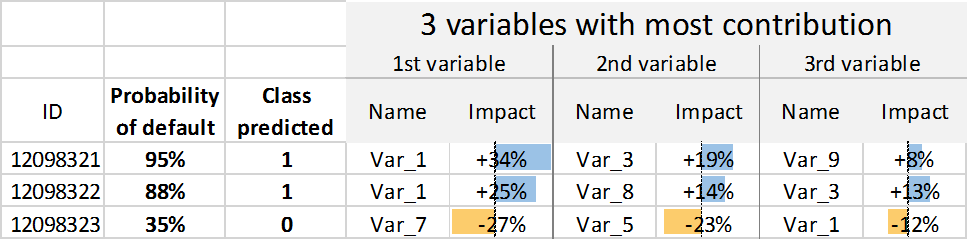

In [11]:
Image('./IMG/top3-vars.png')

#### The most interesting takeaways from this interpretation

"Interpreting each individual prediction can be used to":

1. "Understand for an individual case the reasons of the prediction":
    - "*Example*: two individuals can have a high probability of default but for completely different reasons (i.e. different variables)".
2. "Understand on a filtered population the most frequent reasons of their predictions. *This is different from feature importance!*":
    - "*Example*: consider a fraud detection use case. This is a classic majority class problem ($0.1\%$ of class 1 data vs $99.9\%$ of class 0 data), and the feature importance is biased towards class 0. So looking at each individual prediction of class 1 and grouping the top 3 variables that explain the most the class 1 will be very interesting to understand what features drive the most the risk".

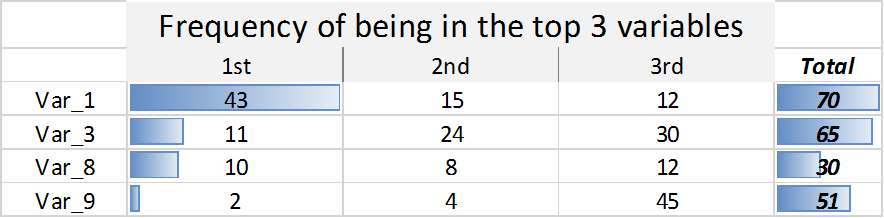

In [12]:
Image('./IMG/top3-vars-frequency.png')

#### Implementation in Python

"The [`treeinterpreter`](https://github.com/andosa/treeinterpreter) library in Python allows us to compute exactly the impact of each feature for a Random Forest model".

> "I let the curious reader check the two amazing articles ([1](http://blog.datadive.net/interpreting-random-forests/) and [2](http://blog.datadive.net/random-forest-interpretation-conditional-feature-contributions/)) from the author of the package".

"For other models, we will do a quick-and-dirty solution: run a Random Forest model, and do local interpretations where predictions between your model and the Random Forest model match (when they both simultaneously predict default or non default)".
- "It is the solution I chose in a client project where I had a XGBoost model".
- "In this case, the local interpretation from Random Forest made a lot of sense, but it is still a frustrating workaround not to have a dedicated framework for XGBoost specifically".

> "As it takes some time to compute (depending on the number of trees in the Random Forest model), I recommend using a subset of your predictions for this exercise. For instance, the 10 individuals most likely to default according to the model".

```{language=python}
from treeinterpreter import treeinterpreter as ti

for i,row in X.iterrows():

    data_point = pd.DataFrame([row])
    data_point.set_axis(['value_variable']) # Once transposed, it will be the column name
    prediction, bias, contributions = ti.predict(rf_model, data_point)
    local_interpretation = data_point.append(
	    pd.DataFrame([[round(c[1],3) for c in contributions[0]]], columns=data_point.columns.tolist(), index=['contribution_variable'])
    ).T.sort_values('contribution_variable', ascending=False)

print(local_interpretation)
```

> "Note that treeinterpreter has both variable contribution, and overall bias. For more in-depth understanding, I recommend the original [blog post](http://blog.datadive.net/interpreting-random-forests/)".

#### One thing to keep in mind

> "Imagine you have a variable 'age', and its contribution is high enough to be in the top 3 variables to contribute to a specific prediction".

>> "You would probably be interested in knowing what the age is, because you (or an expert) will interpret differently an age of 18 or 35".

>> "So it's a good habit to look at the contribution of a variable along with its value (like in the code above, where there are the two columns `value_variable` and `contribution_variable`)".

***

## To go beyond `treeinterpreter`

"Interpreting black-box models has been the subject of many research papers and is currently, especially when it comes to [deep learning interpretation](https://deepmind.com/blog/article/understanding-deep-learning-through-neuron-deletion)".
- "Different methods have been tested and adopted: [LIME](https://github.com/marcotcr/lime), [partial dependence plots](https://scikit-learn.org/stable/modules/partial_dependence.html), [defragTrees](https://github.com/sato9hara/defragTrees)..."

***

For more on the interpretation of Random Forests, see [this link](https://medium.com/usf-msds/intuitive-interpretation-of-random-forest-2238687cae45).
